# 2. Run segmentation free methods

We want to perform segmentation-free methods in order to identify areas that locally resemble cell bodies and, thus, could be considered as intracellular. In this notebook we perform segmentation-free analysis with different algorithms (t.b.a)

## Import packages

In [1]:
import spatialdata as sd

import troutpy

/opt/anaconda3/envs/troutpy_dev_2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/troutpy_dev_2/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Read SpatialData dataset

We read the sdata cropped object we created in ``0.format_xenium_sdata.ipynb``

In [2]:
xenium_path_cropped = "/Users/michaeldammann/Downloads/mousebrain_prime_crop.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

### Run  segmentation-free (points2regions)

We use ``troutpy.tl.segmentation_free_clustering`` to perform segmentation-free clustering. Several segmentation-free algorithms are implemented within troutpy. In this case, we apply points2regions (Andersson et al. 2024) to define the main segmentation-free clusters 

In [3]:
# define points2regions_params
points2regions_params = {"num_clusters": 100, "pixel_width": 0.4, "pixel_smoothing": 3.5}
# run_segmentation_free
troutpy.tl.segmentation_free_clustering(sdata, params=points2regions_params, x="x", y="y", feature_name="feature_name", transcript_id="transcript_id")

Creating anndata


In [4]:
sdata.points["transcripts"]["x"]

Dask Series Structure:
npartitions=1
0          float32
5132695        ...
Name: x, dtype: float32
Dask Name: getitem, 31 graph layers

The output of segmentation-free clustering is stored in ``sdata.tables['segmentation_free_table']`` as an AnnData object. In this object, every observation corresponds to an analyzed transcript, which has a Cluster assigned.

In [5]:
sdata.tables["segmentation_free_table"]

AnnData object with n_obs × n_vars = 2114819 × 13035
    obs: 'Clusters'
    uns: 'reads'
    obsm: 'spatial'

## Define extracellular transcripts

Next, we will use the output of segmentation and segmentation-free analysis to define extracellular transcripts. For this, we will employ the command ``troutpy.pp.define_extracellular``. Essentially, extracellular transcripts will be defined as those:
- Located outside segmented cells
- Assigned to segmentation-free clusters that aren't mainly located inside segmented cells (thus, enriched outside)

In [6]:
troutpy.pp.define_extracellular(sdata, method="segmentation_free", min_prop_of_extracellular=0.8)

As an output, a new column `extracellular` is created in ``sdata.points['transcripts']``. All reads considered extracellulared are assigned to True in this column. Following analysis will employ this column to divide cellular and extracellular transcripts

In [7]:
sdata.points["transcripts"]["extracellular"]

Dask Series Structure:
npartitions=1
0          bool
5132695     ...
Name: extracellular, dtype: bool
Dask Name: getitem, 31 graph layers

## Write processed output

Finally we save the processed sdata object with defined extracellular transcripts as sdata

In [8]:
xenium_path_cropped = "mousebrain_prime_crop_points2regions.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside mousebrain_prime_crop_points2regions.zarr). Please see the documentation of             
         `is_self_contained()` to understand the implications of working with SpatialData objects that are not     
         self-contained.                                                                                           
INFO     The Zarr backing store has been changed from /Users/michaeldammann/Downloads/mousebrain_prime_crop.zarr   
         the new file path: mousebrain_prime_crop_points2regions.zarr                                              


### -- TO DO -- Work on the visualization of extracellular transcripts quantification

#### PLOTTING FUNCTION 1 (troutpy.pl)-  extracellular_proportion identified
- **Aim**: Represent the proportion of extracellular transcripts
- **Input**: sdata, specifically in `sdata.points["transcripts"]['extracellular']` there is boolean classification of RNA in intracellular vs extracellular. Optional, group_key: for grouping transcripts by key(i.e.genes, segmentation_free cluster etc.)
- **Suggested Type of plot**: Either stacked barplot, pie plot ,segment plot
-  **Returns**: None (besides the plot) 

In [41]:
# Pie-plot wise, you can take as reference
input_data = sdata.points["transcripts"][["missegmentation_associated"]].compute()
troutpy.pl.pie_of_positive(input_data, groupby="missegmentation_associated", save=True)

KeyError: "None of [Index(['missegmentation_associated'], dtype='object')] are in the [columns]"

<Figure size 640x480 with 0 Axes>

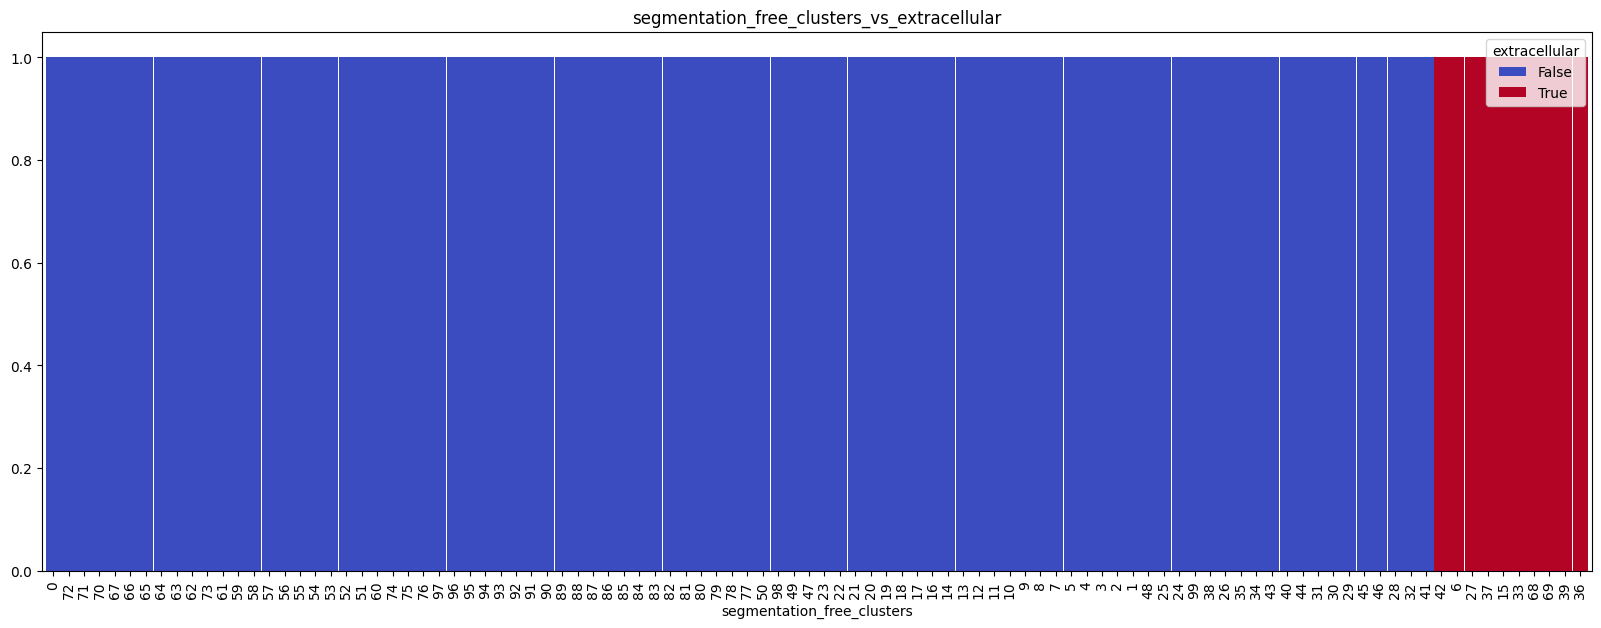

In [17]:
### barplot wise, you can take this as reference
plot_data = sdata.points["transcripts"][["segmentation_free_clusters", "extracellular"]].compute()
troutpy.pl.plot_crosstab(
    plot_data,xvar="segmentation_free_clusters",
    yvar="extracellular", normalize=True,
    axis=1, kind="bar",figsize=(20, 7),
    stacked=True,cmap="coolwarm", sortby=True)

# Example usage

<Figure size 640x480 with 0 Axes>

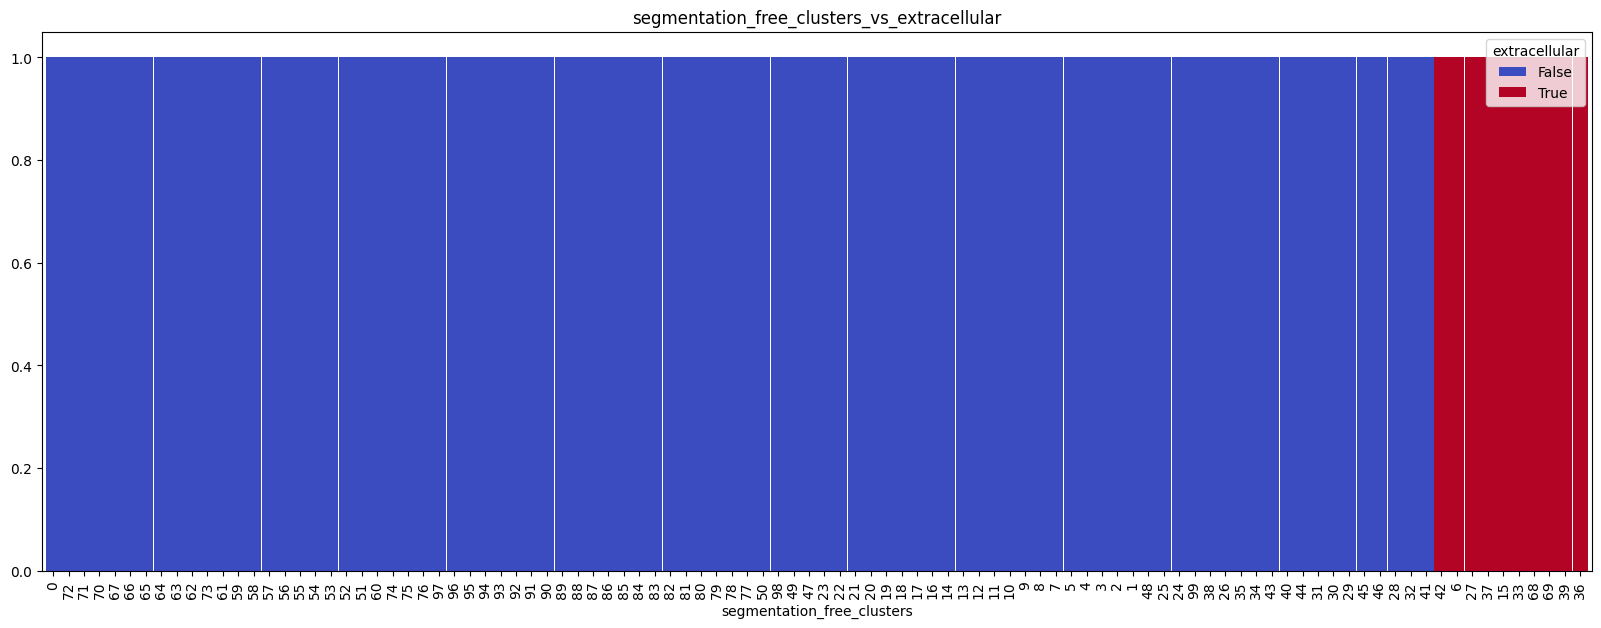

<Figure size 640x480 with 0 Axes>

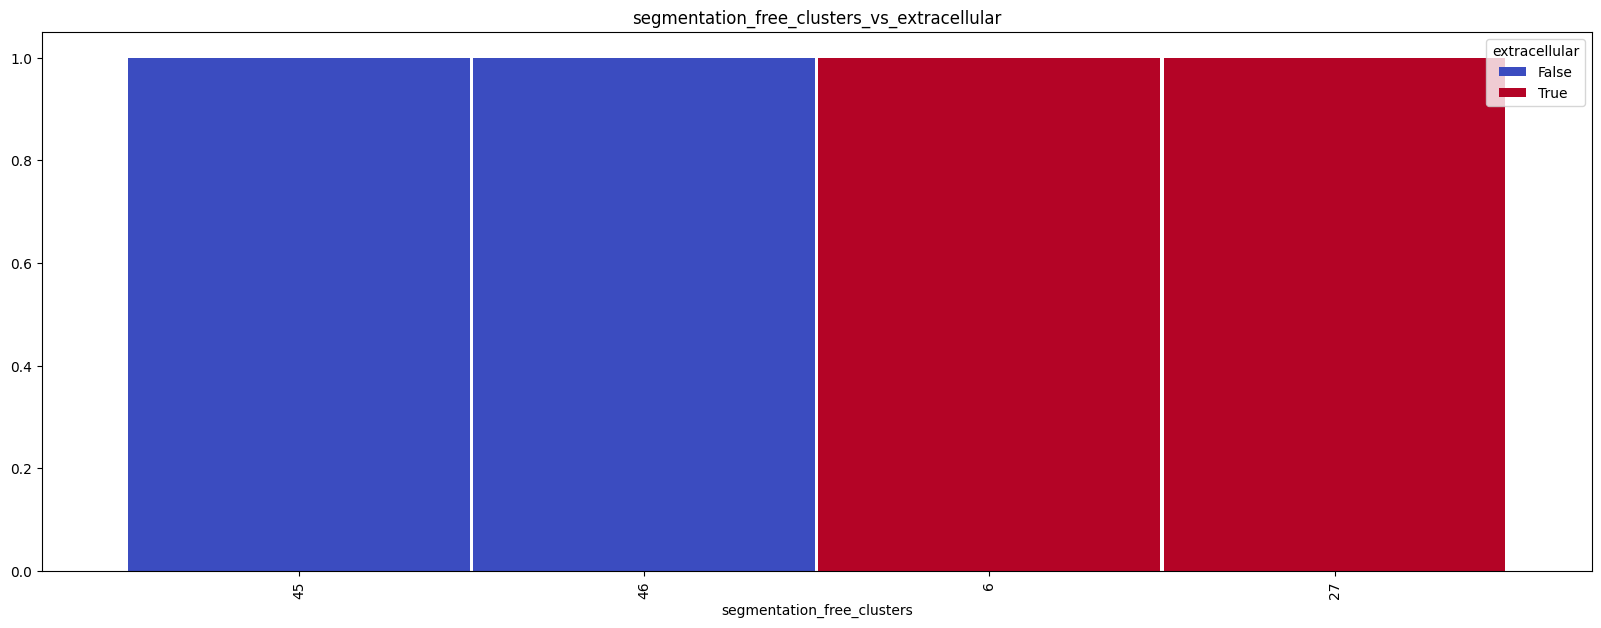

In [10]:
from troutpy.pl import barplot_quantified_extracellular_by_group_key

# For all values in segmentation_free_clusters:
barplot_quantified_extracellular_by_group_key(sdata, group_key = "segmentation_free_clusters")

# Only for some values in segmentation_free_clusters:
barplot_quantified_extracellular_by_group_key(sdata, group_key = "segmentation_free_clusters", group_key_filter_vals=[45, 46, 6, 27])

For all values: 
Only for some values: 


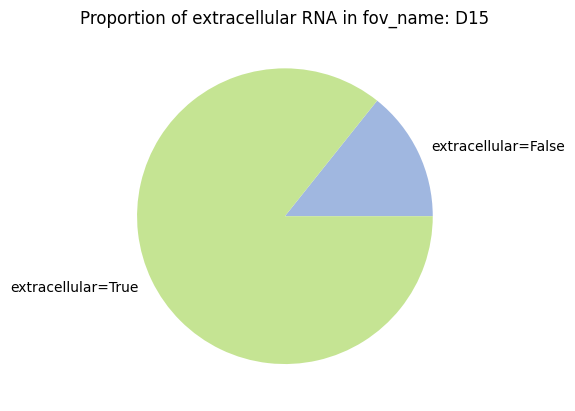

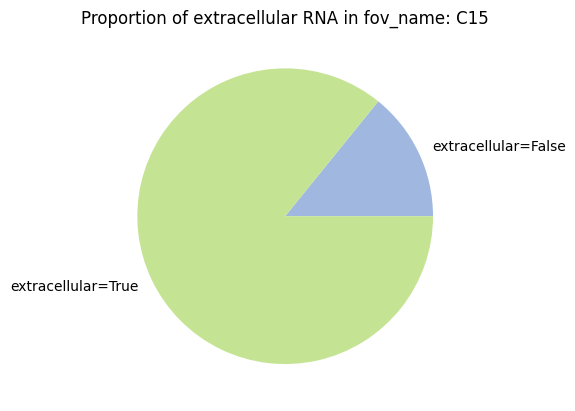

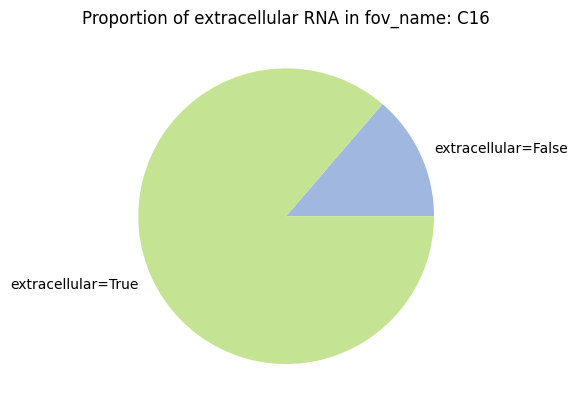

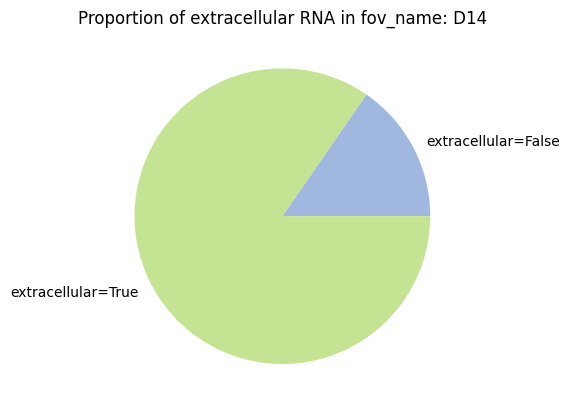

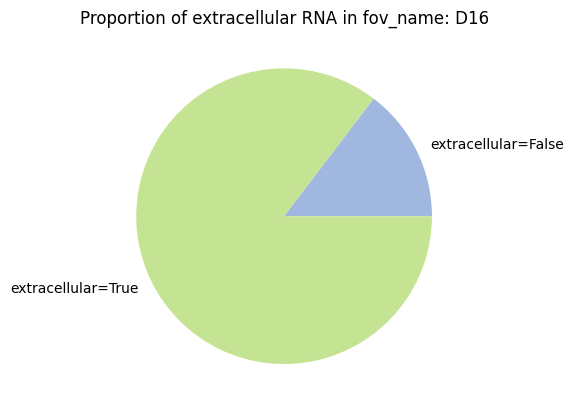

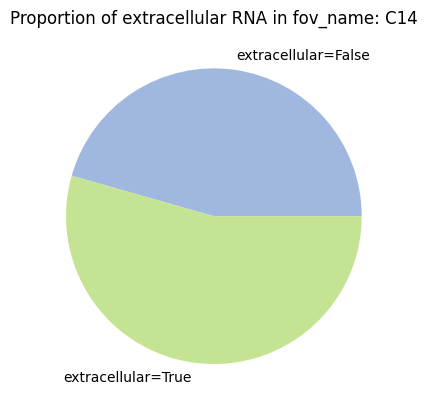

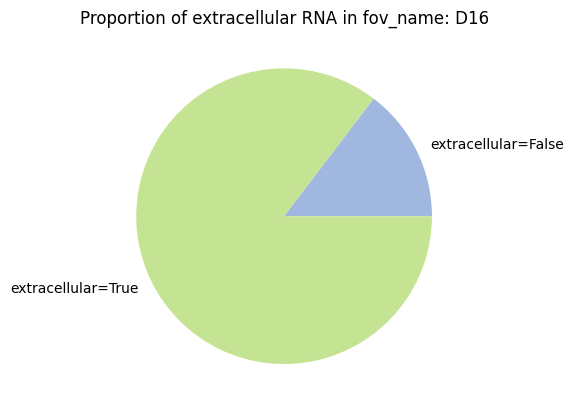

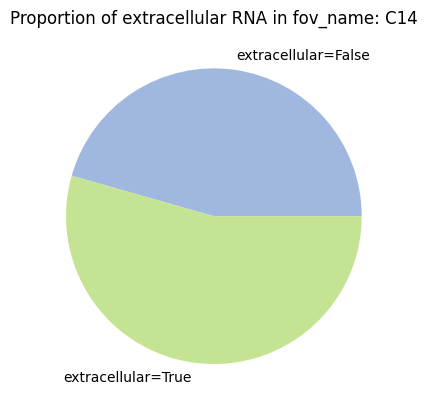

In [14]:
from troutpy.pl import pieplot_quantified_extracellular_by_group_key

# For all values in fov_name:
pieplot_quantified_extracellular_by_group_key(sdata, group_key = "fov_name", group_key_filter_vals=None)

# Only for some values in fov_name:
pieplot_quantified_extracellular_by_group_key(sdata, group_key = "fov_name", group_key_filter_vals=['D16', 'C14'])